In [1]:
import pandas as pd 
import numpy as np 
import scanpy as sc 
import os 
import warnings 
warnings.filterwarnings("ignore") 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import PROST 
PROST.__version__ 

' 1.1.2 '

In [2]:
# the location of R (used for the mclust clustering)
#ENVpath = "your path of PROST_ENV"            # refer to 'How to use PROST' section  
#os.environ['R_HOME'] = f'{ENVpath}/lib/R'
#os.environ['R_USER'] = f'{ENVpath}/lib/python3.7/site-packages/rpy2'

# init
SEED = 818
PROST.setup_seed(SEED)

# Set directory (If you want to use additional data, please change the file path)
rootdir = 'datasets/SeqFISH/'

input_dir = os.path.join(rootdir)
output_dir = os.path.join(rootdir,'results/')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# Read counts and metadata
counts = pd.read_csv(input_dir + "counts.txt", sep = "\t")
metadata = pd.read_csv(input_dir + "metadata.txt", sep = "\t")
gene_name = counts.index

In [3]:
# Choose embryo1 (embryo2 or embryo3)
embryo = 1

In [4]:
# Read data
metadata = metadata[metadata["embryo"]==f"embryo{embryo}"]
counts = counts.loc[:,metadata["uniqueID"]]
spatial = metadata[["x_global","y_global"]]
spatial.index = metadata["uniqueID"]

# Create anndata
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()
# read spatial
adata.obsm["spatial"] = spatial.to_numpy()
# read annotation
annotation = metadata["celltype_mapped_refined"]
annotation.index = metadata["uniqueID"]
adata.obs["annotation"] = annotation
# save data
adata.write_h5ad(output_dir+f"/used_data_embryo{embryo}.h5")

... storing 'annotation' as categorical


In [5]:
# Calculate PI
adata = sc.read(output_dir+f"/used_data_embryo{embryo}.h5")
adata = PROST.prepare_for_PI(adata, percentage = 0.01, platform="SeqFISH")
adata = PROST.cal_PI(adata, kernel_size=8, platform="SeqFISH",del_rate=0.05)

# Hypothesis test
'''
PROST.spatial_autocorrelation(adata, k = 10, permutations = None)
'''

# Save PI results
adata.write_h5ad(output_dir+f"/PI_result_embryo{embryo}.h5")

Trying to set attribute `.var` of view, copying.



Filtering genes ...

Normalization to each gene:


100%|██████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 6748.45it/s]



Gaussian filtering for each gene:


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [00:39<00:00,  8.91it/s]



Binary segmentation for each gene:


100%|█████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 18469.69it/s]



Spliting subregions for each gene:


100%|██████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 7975.47it/s]



Computing PROST Index for each gene:


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [00:39<00:00,  8.94it/s]


PROST Index calculation completed !!



Drawing pictures:


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.63s/it]



Drawing completed !!


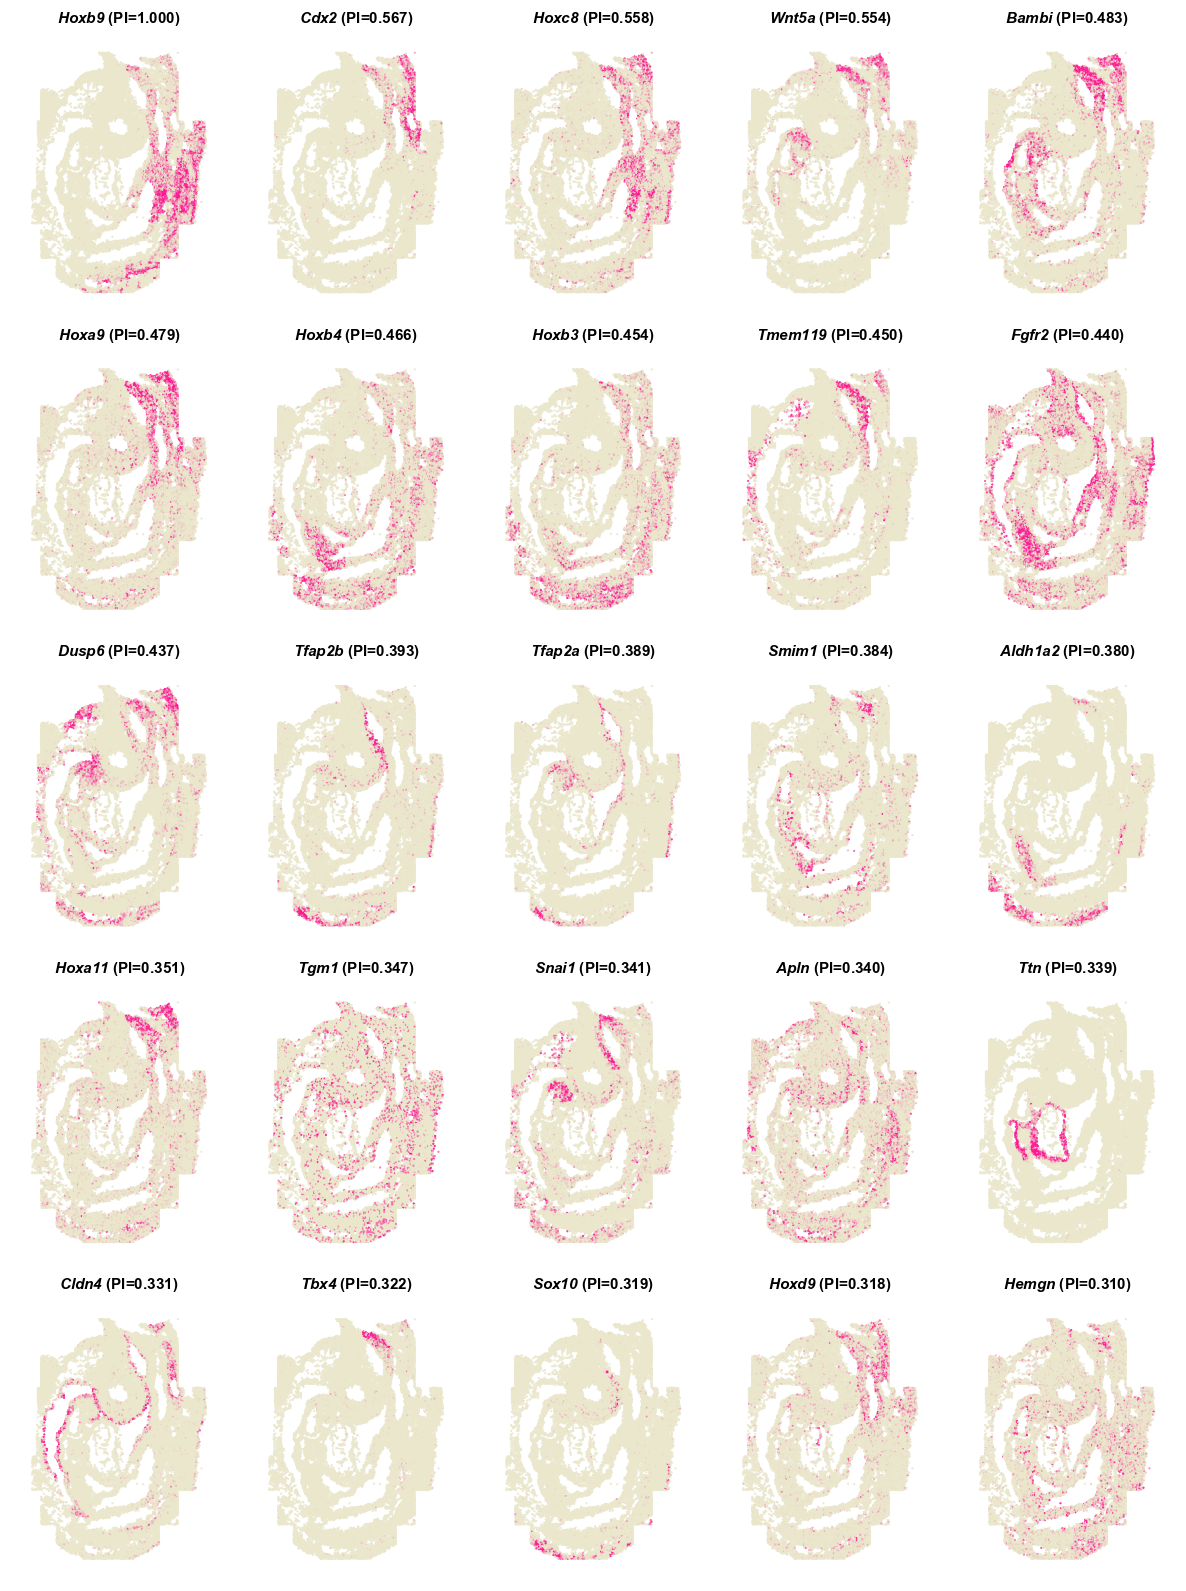

In [6]:
PROST.plot_gene(adata, platform="SeqFISH", size = 0.3, top_n = 25, ncols_each_sheet = 5, nrows_each_sheet = 5,save_path = output_dir)

In [7]:
PROST.setup_seed(SEED)
# Read PI result
adata = sc.read(output_dir+f"/PI_result_embryo{embryo}.h5")
# Preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# Set the number of clusters
n_clusters = 24

In [8]:
PROST.run_PNN(adata, 
            platform="SeqFISH", 
            min_distance = 3,
            init="mclust",
            n_clusters = n_clusters, 
            SEED=SEED,
            post_processing = False,
            cuda = False)


Calculating adjacency matrix ...

Running PCA ...
Laplacian Smoothing ...

Initializing cluster centers with mclust, n_clusters known


Epoch: : 501it [3:20:22, 24.00s/it, loss=0.28359604]                                                                   


Clustering completed !!


AnnData object with n_obs × n_vars = 19451 × 351
    obs: 'annotation', 'clustering'
    var: 'n_cells', 'SEP', 'SIG', 'PI'
    uns: 'binary_image', 'del_index', 'gau_fea', 'grid_size', 'locates', 'nor_counts', 'shape', 'subregions', 'log1p'
    obsm: 'spatial', 'PROST'

In [9]:
# Save clustering results
adata.write_h5ad(output_dir + f"/PNN_result_embryo{embryo}.h5")
clustering = adata.obs["clustering"]
clustering.to_csv(output_dir + f"/clusters_embryo{embryo}.csv",header = False)
embedding = adata.obsm["PROST"]
np.savetxt(output_dir + f"/embedding_embryo{embryo}.txt",embedding)

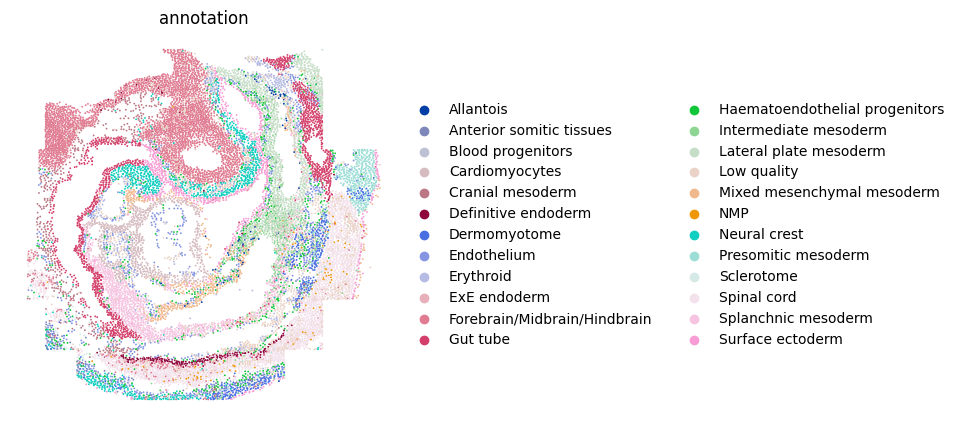

In [10]:
# Plot annotation 
plt.rcParams["figure.figsize"] = (5,5)
ax = sc.pl.embedding(adata, basis="spatial", color="annotation",size = 7,s=6, show=False, title='annotation')
ax.invert_yaxis()
plt.axis('off')
plt.savefig(output_dir+f"/annotation_embryo{embryo}.png", dpi=600, bbox_inches='tight')

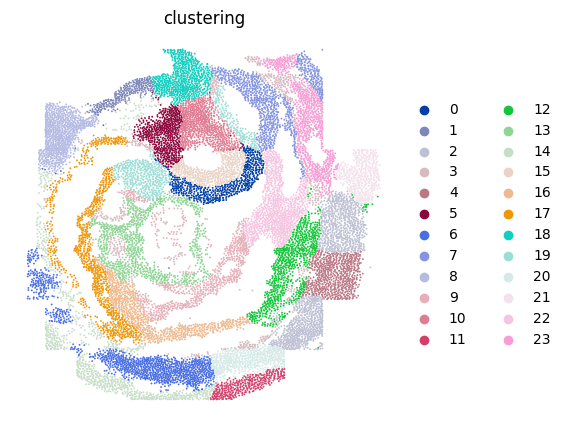

In [11]:
# Plot clustering results
plt.rcParams["figure.figsize"] = (5,5)
ax = sc.pl.embedding(adata, basis="spatial", color="clustering",size=7,s=6, show=False, title='clustering')
ax.invert_yaxis()
plt.axis('off')
plt.savefig(output_dir+f"/clustering_embryo{embryo}.png", dpi=600, bbox_inches='tight')